In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score
import copy

from src.train import trainModel

#from src.dataloader import getData,spliceDataset,h5pyDataset,collate_fn
from src.dataloader import get_GTEX_v8_Data,spliceDataset,h5pyDataset,getDataPointList,getDataPointListGTEX,DataPointGTEX
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d,kl_div_2d
from src.model import SpliceFormer
from src.evaluation_metrics import print_topl_statistics,cross_entropy_2d

In [2]:
!nvidia-smi

Wed Jun  7 18:00:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-DGXS-32GB            Off| 00000000:07:00.0 Off |                    0 |
| N/A   38C    P0               39W / 300W|      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
#!pip install pickle5

In [4]:
rng = np.random.default_rng(23673)

In [5]:
#gtf = None

In [6]:
L = 32
N_GPUS = 3
k = 2
NUM_ACCUMULATION_STEPS=1
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = 16*k*N_GPUS

k = NUM_ACCUMULATION_STEPS*k

CL = 2 * np.sum(AR*(W-1))

In [7]:
from collections import defaultdict

In [8]:
data_dir = '/odinn/tmp/benediktj/Data/SplicePrediction-rnasplice-blood-070623/'
setType = 'train'
annotation, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')

In [9]:
#gene_to_label_2 = defaultdict(list)
#for key in tqdm(gene_to_label.keys()):
#    jn_start, jn_end = gene_to_label[key]
#    jn_starts = defaultdict(int)
#    jn_ends = defaultdict(int)
#    for jn in jn_start:
#        jn_starts[jn] = 1
#    for jn in jn_end:
#        jn_ends[jn] = 1
#    gene_to_label_2[key] = [jn_starts,jn_ends]
    
#gene_to_label = gene_to_label_2

In [10]:
# Maximum nucleotide context length (CL_max/2 on either side of the 
# position of interest)
# CL_max should be an even number
# Sequence length of SpliceAIs (SL+CL will be the input length and
# SL will be the output length)

SL=5000
CL_max=40000

In [11]:
assert CL_max % 2 == 0

In [12]:
train_gene, validation_gene = train_test_split(annotation['gene'].drop_duplicates(),test_size=.1,random_state=435)
annotation_train = annotation[annotation['gene'].isin(train_gene)]
annotation_validation = annotation[annotation['gene'].isin(validation_gene)]

In [13]:
#with open('{}/sparse_discrete_gene_label_data_{}.pickle'.format(data_dir,setType), 'rb') as handle:
#    gene_to_label_old = pickle.load(handle)

In [14]:
#for gene in gene_to_label_old.keys():
#    if len(gene_to_label[gene])==0:
#        gene_to_label[gene] = gene_to_label_old[gene]

In [15]:
train_dataset = spliceDataset(getDataPointListGTEX(annotation_train,gene_to_label,SL,CL_max,shift=SL))
val_dataset = spliceDataset(getDataPointListGTEX(annotation_validation,gene_to_label,SL,CL_max,shift=SL))
train_dataset.seqData = seqData
val_dataset.seqData = seqData

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=16)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 4
hs = []
learning_rate= k*1e-4
gamma=0.5
temp = 1
#final_lr = 1e-5
#gamma = 1/(learning_rate/final_lr)**(1/5) 

Epoch (train) 1/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:19<00:00,  2.27s/it, a_r=0.614, d_r=0.611, loss=0.000926, r_a=0.989, r_d=0.988, r_loss=6.52]


epoch: 1/4, train loss = 0.001014


Epoch (val) 1/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 633/633 [11:21<00:00,  1.08s/it, a_r=0.583, d_r=0.568, loss=0.00125, r_a=0.989, r_d=0.988, r_loss=7.83]



Acceptor:
0.9956	0.7237	0.853	0.9343	0.8115	0.9680	0.2203	0.0624	0.0161	16065	22199.0	22199

Donor:
0.9961	0.7253	0.859	0.936	0.8145	0.9605	0.2059	0.0583	0.0146	16352	22545.0	22545
epoch: 1/4, val loss = 0.000963


Epoch (train) 2/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:02<00:00,  2.26s/it, a_r=0.62, d_r=0.623, loss=0.000893, r_a=0.991, r_d=0.99, r_loss=6.44]


epoch: 2/4, train loss = 0.000912


Epoch (val) 2/4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 633/633 [11:24<00:00,  1.08s/it, a_r=0.581, d_r=0.597, loss=0.00122, r_a=0.991, r_d=0.99, r_loss=7.8]



Acceptor:
0.9957	0.726	0.8602	0.9402	0.8171	0.9678	0.2277	0.0673	0.0164	16117	22199.0	22199

Donor:
0.9957	0.7298	0.8652	0.9407	0.8196	0.9640	0.2342	0.0675	0.0166	16453	22545.0	22545
epoch: 2/4, val loss = 0.000939


Epoch (train) 3/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [54:59<00:00,  2.26s/it, a_r=0.627, d_r=0.629, loss=0.000877, r_a=0.99, r_d=0.99, r_loss=6.05]


epoch: 3/4, train loss = 0.000886


Epoch (val) 3/4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 633/633 [11:24<00:00,  1.08s/it, a_r=0.567, d_r=0.577, loss=0.00126, r_a=0.99, r_d=0.99, r_loss=7.26]



Acceptor:
0.9958	0.7267	0.8601	0.9367	0.8162	0.9517	0.1790	0.0459	0.0106	16132	22199.0	22199

Donor:
0.9949	0.7276	0.8634	0.9401	0.8173	0.9572	0.1971	0.0544	0.0146	16403	22545.0	22545
epoch: 3/4, val loss = 0.000959


Epoch (train) 4/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:09<00:00,  2.26s/it, a_r=0.625, d_r=0.63, loss=0.000864, r_a=0.991, r_d=0.99, r_loss=6.22]


epoch: 4/4, train loss = 0.000867


Epoch (val) 4/4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 633/633 [11:27<00:00,  1.09s/it, a_r=0.571, d_r=0.61, loss=0.00121, r_a=0.991, r_d=0.99, r_loss=7.79]



Acceptor:
0.9956	0.7314	0.8669	0.9425	0.8213	0.9515	0.2019	0.0571	0.0135	16237	22199.0	22199

Donor:
0.9952	0.7334	0.8692	0.9439	0.8233	0.9660	0.2548	0.0730	0.0176	16534	22545.0	22545
epoch: 4/4, val loss = 0.000927


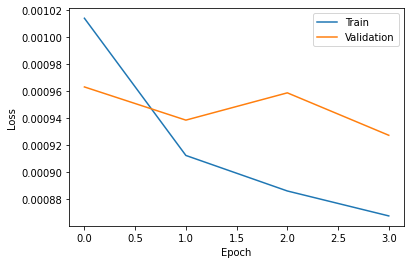

Epoch (train) 1/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:10<00:00,  2.27s/it, a_r=0.614, d_r=0.624, loss=0.000916, r_a=0.99, r_d=0.989, r_loss=5.7]


epoch: 1/4, train loss = 0.001020


Epoch (train) 2/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:04<00:00,  2.26s/it, a_r=0.616, d_r=0.617, loss=0.000899, r_a=0.99, r_d=0.99, r_loss=5.72]


epoch: 2/4, train loss = 0.000914


Epoch (train) 3/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:08<00:00,  2.26s/it, a_r=0.624, d_r=0.628, loss=0.000897, r_a=0.99, r_d=0.99, r_loss=5.83]


epoch: 3/4, train loss = 0.000886


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:09<00:00,  2.27s/it, a_r=0.626, d_r=0.628, loss=0.000881, r_a=0.99, r_d=0.989, r_loss=5.82]


epoch: 4/4, train loss = 0.000866


Epoch (train) 1/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:06<00:00,  2.26s/it, a_r=0.618, d_r=0.617, loss=0.000924, r_a=0.989, r_d=0.988, r_loss=6.04]


epoch: 1/4, train loss = 0.001015


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:03<00:00,  2.26s/it, a_r=0.621, d_r=0.629, loss=0.000898, r_a=0.99, r_d=0.989, r_loss=5.85]


epoch: 2/4, train loss = 0.000911


Epoch (train) 3/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:00<00:00,  2.26s/it, a_r=0.626, d_r=0.623, loss=0.000886, r_a=0.99, r_d=0.989, r_loss=5.88]


epoch: 3/4, train loss = 0.000885


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:00<00:00,  2.26s/it, a_r=0.634, d_r=0.641, loss=0.000851, r_a=0.991, r_d=0.99, r_loss=5.79]


epoch: 4/4, train loss = 0.000865


Epoch (train) 1/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:06<00:00,  2.26s/it, a_r=0.612, d_r=0.612, loss=0.000956, r_a=0.981, r_d=0.985, r_loss=3.68]


epoch: 1/4, train loss = 0.001013


Epoch (train) 2/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:10<00:00,  2.27s/it, a_r=0.619, d_r=0.623, loss=0.000911, r_a=0.985, r_d=0.987, r_loss=3.46]


epoch: 2/4, train loss = 0.000913


Epoch (train) 3/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:09<00:00,  2.27s/it, a_r=0.618, d_r=0.625, loss=0.000911, r_a=0.985, r_d=0.986, r_loss=3.46]


epoch: 3/4, train loss = 0.000887


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:06<00:00,  2.26s/it, a_r=0.629, d_r=0.628, loss=0.00085, r_a=0.988, r_d=0.988, r_loss=3.28]


epoch: 4/4, train loss = 0.000867


Epoch (train) 1/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:06<00:00,  2.26s/it, a_r=0.617, d_r=0.619, loss=0.000934, r_a=0.989, r_d=0.988, r_loss=5.64]


epoch: 1/4, train loss = 0.001016


Epoch (train) 2/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:03<00:00,  2.26s/it, a_r=0.619, d_r=0.626, loss=0.00091, r_a=0.99, r_d=0.989, r_loss=5.56]


epoch: 2/4, train loss = 0.000914


Epoch (train) 3/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:13<00:00,  2.27s/it, a_r=0.626, d_r=0.63, loss=0.000868, r_a=0.991, r_d=0.99, r_loss=5.45]


epoch: 3/4, train loss = 0.000887


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:08<00:00,  2.26s/it, a_r=0.627, d_r=0.626, loss=0.000871, r_a=0.991, r_d=0.99, r_loss=5.41]


epoch: 4/4, train loss = 0.000868


Epoch (train) 1/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:12<00:00,  2.27s/it, a_r=0.613, d_r=0.619, loss=0.000938, r_a=0.989, r_d=0.989, r_loss=9.68]


epoch: 1/4, train loss = 0.001012


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:05<00:00,  2.26s/it, a_r=0.62, d_r=0.62, loss=0.000901, r_a=0.99, r_d=0.99, r_loss=9.2]


epoch: 2/4, train loss = 0.000916


Epoch (train) 3/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:08<00:00,  2.26s/it, a_r=0.62, d_r=0.629, loss=0.000877, r_a=0.99, r_d=0.989, r_loss=9.01]


epoch: 3/4, train loss = 0.000889


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:13<00:00,  2.27s/it, a_r=0.626, d_r=0.632, loss=0.000875, r_a=0.991, r_d=0.99, r_loss=8.69]


epoch: 4/4, train loss = 0.000871


Epoch (train) 1/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:17<00:00,  2.27s/it, a_r=0.612, d_r=0.617, loss=0.000928, r_a=0.989, r_d=0.989, r_loss=9.22]


epoch: 1/4, train loss = 0.001011


Epoch (train) 2/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:11<00:00,  2.27s/it, a_r=0.623, d_r=0.625, loss=0.000911, r_a=0.99, r_d=0.99, r_loss=9.11]


epoch: 2/4, train loss = 0.000914


Epoch (train) 3/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:11<00:00,  2.27s/it, a_r=0.623, d_r=0.626, loss=0.000876, r_a=0.991, r_d=0.989, r_loss=8.84]


epoch: 3/4, train loss = 0.000888


Epoch (train) 4/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:04<00:00,  2.26s/it, a_r=0.628, d_r=0.629, loss=0.000865, r_a=0.992, r_d=0.991, r_loss=8.81]


epoch: 4/4, train loss = 0.000868


Epoch (train) 1/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:18<00:00,  2.27s/it, a_r=0.611, d_r=0.616, loss=0.000962, r_a=0.99, r_d=0.988, r_loss=8.86]


epoch: 1/4, train loss = 0.001010


Epoch (train) 2/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:06<00:00,  2.26s/it, a_r=0.616, d_r=0.627, loss=0.000894, r_a=0.99, r_d=0.989, r_loss=8.3]


epoch: 2/4, train loss = 0.000913


Epoch (train) 3/4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:09<00:00,  2.27s/it, a_r=0.621, d_r=0.63, loss=0.00088, r_a=0.991, r_d=0.99, r_loss=8.23]


epoch: 3/4, train loss = 0.000887


Epoch (train) 4/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:03<00:00,  2.26s/it, a_r=0.63, d_r=0.632, loss=0.000865, r_a=0.991, r_d=0.99, r_loss=8.29]


epoch: 4/4, train loss = 0.000867


Epoch (train) 1/4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:15<00:00,  2.27s/it, a_r=0.614, d_r=0.616, loss=0.000944, r_a=0.989, r_d=0.989, r_loss=9.31]


epoch: 1/4, train loss = 0.001014


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:03<00:00,  2.26s/it, a_r=0.623, d_r=0.627, loss=0.000901, r_a=0.991, r_d=0.99, r_loss=8.98]


epoch: 2/4, train loss = 0.000916


Epoch (train) 3/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:14<00:00,  2.27s/it, a_r=0.626, d_r=0.624, loss=0.000883, r_a=0.991, r_d=0.99, r_loss=9.15]


epoch: 3/4, train loss = 0.000890


Epoch (train) 4/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:11<00:00,  2.27s/it, a_r=0.63, d_r=0.635, loss=0.000868, r_a=0.991, r_d=0.99, r_loss=8.92]


epoch: 4/4, train loss = 0.000871


Epoch (train) 1/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:12<00:00,  2.27s/it, a_r=0.616, d_r=0.618, loss=0.000934, r_a=0.99, r_d=0.988, r_loss=8.8]


epoch: 1/4, train loss = 0.001017


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:12<00:00,  2.27s/it, a_r=0.624, d_r=0.631, loss=0.000908, r_a=0.99, r_d=0.988, r_loss=8.88]


epoch: 2/4, train loss = 0.000918


Epoch (train) 3/4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:12<00:00,  2.27s/it, a_r=0.621, d_r=0.629, loss=0.00089, r_a=0.99, r_d=0.989, r_loss=8.62]


epoch: 3/4, train loss = 0.000891


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [55:10<00:00,  2.27s/it, a_r=0.628, d_r=0.634, loss=0.000855, r_a=0.992, r_d=0.99, r_loss=8.94]

epoch: 4/4, train loss = 0.000873


In [17]:
for model_nr in range(10):
    model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2)
    model_m.apply(keras_init)
    model_m = model_m.to(device)
    if torch.cuda.device_count() > 1:
        #print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model_m = nn.DataParallel(model_m)
    
    model_m.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(model_nr)))
    modelFileName = '../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_050623_{}'.format(model_nr)
    loss = categorical_crossentropy_2d().loss
    #loss = kl_div_2d(temp=temp).loss
    optimizer = torch.optim.AdamW(model_m.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    warmup = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=100)
    if model_nr>0:
        h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=True,lowValidationGPUMem=True,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS,CL_max=CL_max,reinforce=True,continous_labels=False)
    else:
        h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=False,lowValidationGPUMem=True,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS,CL_max=CL_max,reinforce=True,continous_labels=False)
        plt.plot(range(epochs),h['loss'],label='Train')
        plt.plot(range(epochs),h['val_loss'],label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    hs.append(h)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/Data/SplicePrediction/gencode_40k_dataset_test_.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

temp = 1
n_models = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_050623_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()
    
Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        outputs = torch.mean(torch.stack(outputs),dim=0)
        #outputs = odds_gmean(torch.stack(outputs))
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [04:37<00:00, 16.34s/it]


In [21]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.0005919684712745654

Acceptor:
0.9965	0.9344	0.9848	0.9889	0.9713	0.9962	0.7748	0.1755	0.0486	13352	14289.0	14289

Donor:
0.9955	0.9372	0.9873	0.9914	0.9741	0.9970	0.8062	0.1961	0.0542	13391	14289.0	14289


In [ ]:
from src.dataloader import getData
data_dir = '/odinn/tmp/benediktj/Data/SplicePrediction-rnasplice-blood-070623/'
setType = 'test'
annotation_test, transcriptToLabel_test, seqData = getData('/odinn/tmp/benediktj/Data/SplicePrediction-050422', setType)    
from src.dataloader import getDataPointListFull,DataPointFull

In [ ]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True,crop=False)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]

for i,model in enumerate(models):
        state_dict = torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_all_050623_{}'.format(i))
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)

#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_all_050623_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)
    #outputs = odds_gmean(outputs)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


In [ ]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

In [22]:
setType = 'test'
annotation_test, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')

In [23]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_050623_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListGTEX(annotation_test,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 803/803 [1:05:23<00:00,  4.89s/it]


In [24]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor>0, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor>0, Y_pred_donor)

Cross entropy = 0.0007022423108514837

Acceptor:
0.9966	0.742	0.8819	0.9537	0.834	0.9342	0.2282	0.0720	0.0187	73366	98870.0	98870

Donor:
0.9965	0.745	0.8793	0.9495	0.8339	0.9405	0.2373	0.0731	0.0192	74583	100114.0	100114


In [2]:
(98870+100114)

198984

In [3]:
73366+74583

147949

In [1]:
(0.742+0.745)/2

0.7435

In [13]:
#df = pd.DataFrame({'Y_true_acceptor':Y_true_acceptor,'Y_pred_acceptor':Y_pred_acceptor,'Y_true_donor':Y_true_donor,'Y_pred_donor':Y_pred_donor})
#df.to_csv('/odinn/tmp/benediktj/Data/SplicePrediction-rnasplice-blood/transformer_40k_test_set_predictions_120123.gz',index=False)